In [1]:
%%capture
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz, colorea_minimo_fila
%mkdir -p ~/temp
%cd ~/temp

## Enunciado
Considere la información del proyecto cuya información aparece en la tabla adjunta:

In [2]:
periodo_probabilidad_b = 19
periodo_probabilidad_a = 17

pregunta_1 = f"1. ¿Cuál es la probabilidad de terminar el proyecto entre {periodo_probabilidad_a} y {periodo_probabilidad_b} semanas?  "
pregunta_2 = "2. Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?  "
pregunta_3 = "3. Partiendo del proyecto en su situación inicial del apartado 1 ¿Se encuentran nivelados los recursos consumidos? De no ser así proceda a su nivelación.  "
pregunta_4 = "4. Partiendo del proyecto en su situación inicial del apartado 1, modifique la planificación del proyecto para poder ejecutarlo con tan sólo 4 recursos como máximo durante los primeros tres periodos, y 8 recursos durante el resto del proyecto.  "

In [3]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?  

2. Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?  

3. Partiendo del proyecto en su situación inicial del apartado 1 ¿Se encuentran nivelados los recursos consumidos? De no ser así proceda a su nivelación.  

4. Partiendo del proyecto en su situación inicial del apartado 1, modifique la planificación del proyecto para poder ejecutarlo con tan sólo 4 recursos como máximo durante los primeros tres periodos, y 8 recursos durante el resto del proyecto.  

In [4]:
# Alargamos el ancho de las celdas
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, varianza,  cur,  recursos, duracion_tope
     ('A',       '---  ',      2,        1,     -100,     2,         1        ),
     ('B',       '---  ',      4,        1,       30,     2,         2        ),
     ('C',       'B    ',      1,        1,   np.inf,     2,         1        ),
     ('D',       'A    ',      3,        1,       50,     2,         1        ),
     ('E',       'B,D  ',      7,        1,       20,     2,         4        ),
     ('F',       'B,C,D ',     4,        1,       10,     1,         2        ),
     ('G',       '---  ',      1,        2,      100,     4,         1        ),
     ('H',       'G    ',     11,        2,       10,     2,         8        ),
     ('I',       'E,F,H',      2,        1,       50,     2,         1        ),
     ('J',       'E,F,H',      8,        1,        5,     2,         7        ),
] ,columns=['activity', 'predecessor', 'duration', 'variance', 'ucr', 'resources', 'cap_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,variance,ucr,resources,cap_duration
activity,,,,,,
A,---,2,1,-100.0,2,1
B,---,4,1,30.0,2,2
C,B,1,1,inf,2,1
D,A,3,1,50.0,2,1
E,"B,D",7,1,20.0,2,4
F,"B,C,D",4,1,10.0,1,2
G,---,1,2,100.0,4,1
H,G,11,2,10.0,2,8
I,"E,F,H",2,1,50.0,2,1


# Solución
## Apartado 1

In [5]:
display(Markdown(pregunta_1))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?  

In [6]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')

### Cuadros de prelaciones expandido

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [7]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J
activities,,,,,,,,,,
A,,,,,,,,,,
B,,,,,,,,,,
C,,True,,,,,,,,
D,True,,,,,,,,,
E,,True,,True,,,,,,
F,,,True,True,,,,,,
G,,,,,,,,,,
H,,,,,,,True,,,
I,,,,,True,True,,True,,


### Grafo PERT con numeración de nodos

Utilizando el cuadro de prelaciones expandido podemos dibujar el grafo Pert correspondiente al proyecto.

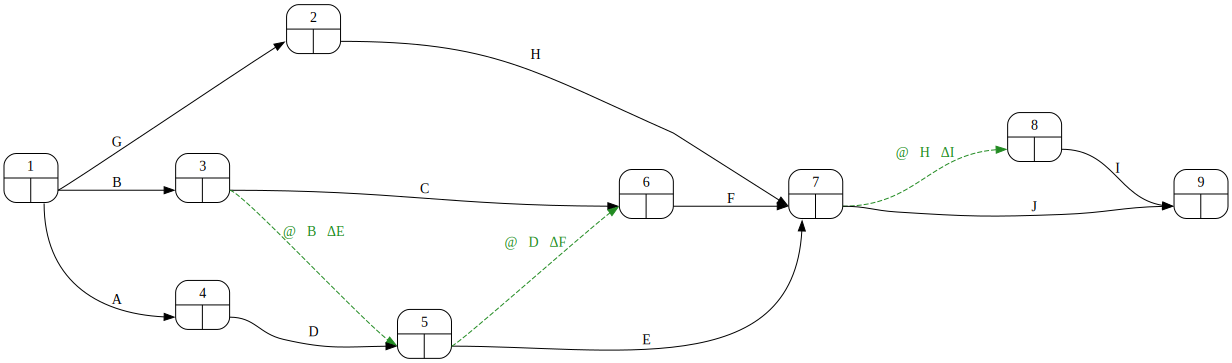

In [8]:
#| fig-cap: "Grafo Pert con indicación con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=1.5, nodesep=1)

Alternativamente podríamos haber representado su grafo Roy.

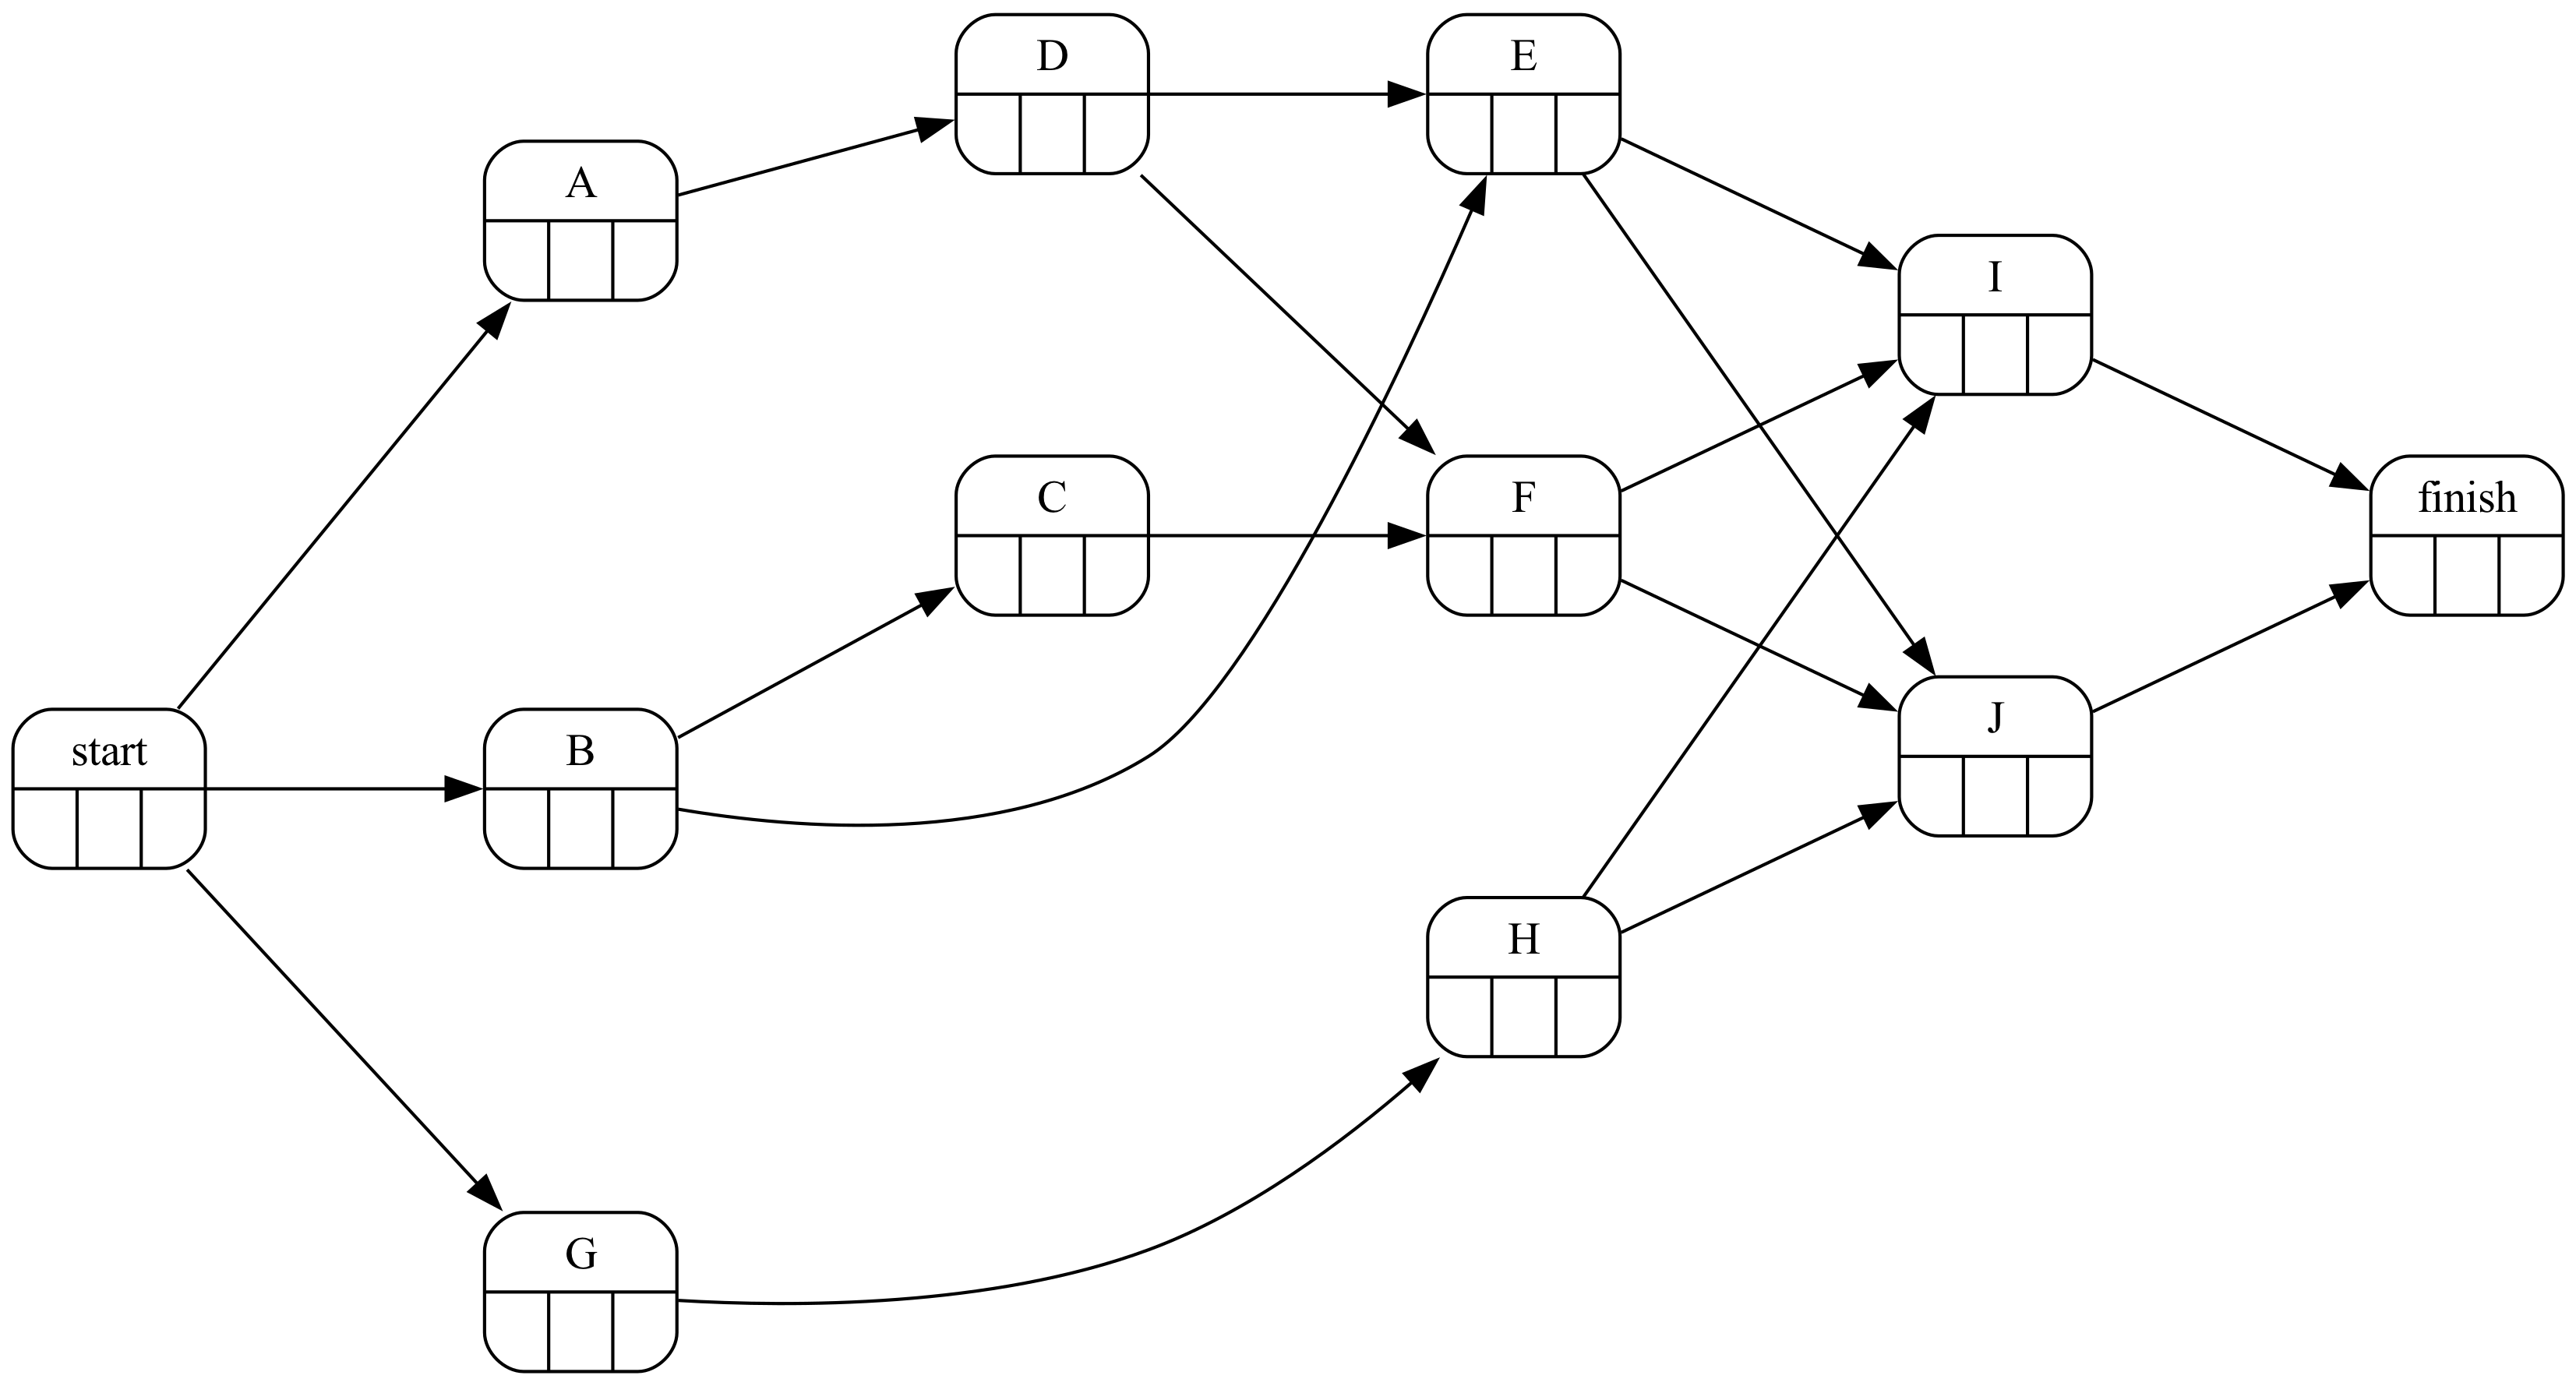

In [9]:
#| fig-cap: "Grafo Roy del proyecto"
#| label: fig-roy
proyecto.roy(ranksep=1.2, nodesep=1.2)

### Matriz de Zaderenko
A continuación podemos determinar la duración del proyecto calculando los tiempos tempranos y tardíos de su grafo Pert. Se hace en este caso mediante el algoritmo de Zaderenko:

In [10]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,1.0,4.0,2.0,,,,,,0.0
2,,,,,,,11.0,,,1.0
3,,,,,0.0,1.0,,,,4.0
4,,,,,3.0,,,,,2.0
5,,,,,,0.0,7.0,,,5.0
6,,,,,,,4.0,,,5.0
7,,,,,,,,0.0,8.0,12.0
8,,,,,,,,,2.0,12.0
9,,,,,,,,,,20.0
late,0.0,1.0,5.0,2.0,5.0,8.0,12.0,18.0,20.0,


Los tiempos tempranos y tardíos obtenidos para cada nodo son:

In [11]:
#| tbl-cap: "Valores de los tiempos tempranos y tardíos de los nodos"
#| label: tbl-TempranosTardios
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,1,1
3,4,5
4,2,2
5,5,5
6,5,8
7,12,12
8,12,18
9,20,20


### Duración media del proyecto

In [12]:
duracion_media_proyecto = proyecto.duration(durations=datos_proyecto['duration'])
Markdown(f"De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es {duracion_media_proyecto} periodos.")

De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es 20 periodos.

### Calendario del proyecto
Las fechas de inicio y fin más tempranas y tardías de cada actividad son:

In [13]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
calendario = proyecto.calendar(datos_proyecto['duration'])
calendario

,inicio_mas_temprano,inicio_mas_tardio,fin_mas_temprano,fin_mas_tardio,H_total,duracion
activity,,,,,,
A,0,0,2,2,0,2
B,0,1,4,5,1,4
C,4,7,5,8,3,1
D,2,2,5,5,0,3
E,5,5,12,12,0,7
F,5,8,9,12,3,4
G,0,0,1,1,0,1
H,1,1,12,12,0,11
I,12,18,14,20,6,2


### Varianza de la duración del proyecto
Para determinar la varianza del proyecto es necesario conocer la varianza de cada una de las rutas del camino crítico. Es necesario, por tanto, conocer cuales son las actividades con holgura total cero.

#### Holgura total de las actividades
Del cálculo de las holguras totales obtenemos:

In [14]:
#| tbl-cap: "Holgura total de las actividades"
#| label: tbl-holguras
resultados_pert['activities']

,H_total
@∇B⤑ΔE,1
@∇D⤑ΔF,3
@∇H⤑ΔI,6
A,0
B,1
C,3
D,0
E,0
F,3
G,0


#### Camino crítico
Las actividades con holgura total cero forman el camino crítico. Según el grafo Pert del proyecto, éste está compuesto por las siguientes rutas, cuyas actividades se listan en orden alfabético:

In [15]:
camino_critico = proyecto.display_critical_path(durations=datos_proyecto['duration'])

- Route_2 :	A, D, E, J <br> 

- Route_12 :	G, H, J <br> 

#### Grafo PERT con indicación del camino crítico

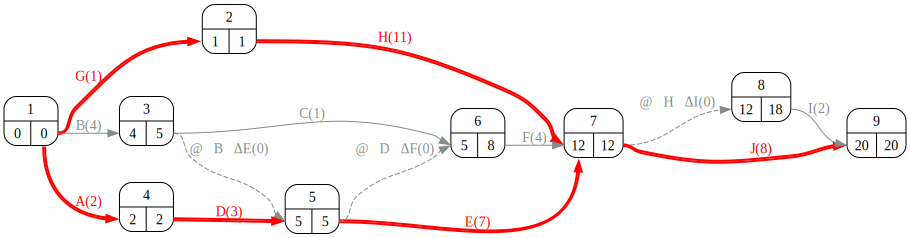

In [16]:
proyecto.pert(durations=datos_proyecto['duration'])

Alternativamente, se muestra el grafo roy correspondiente con indicación del camino crítico.

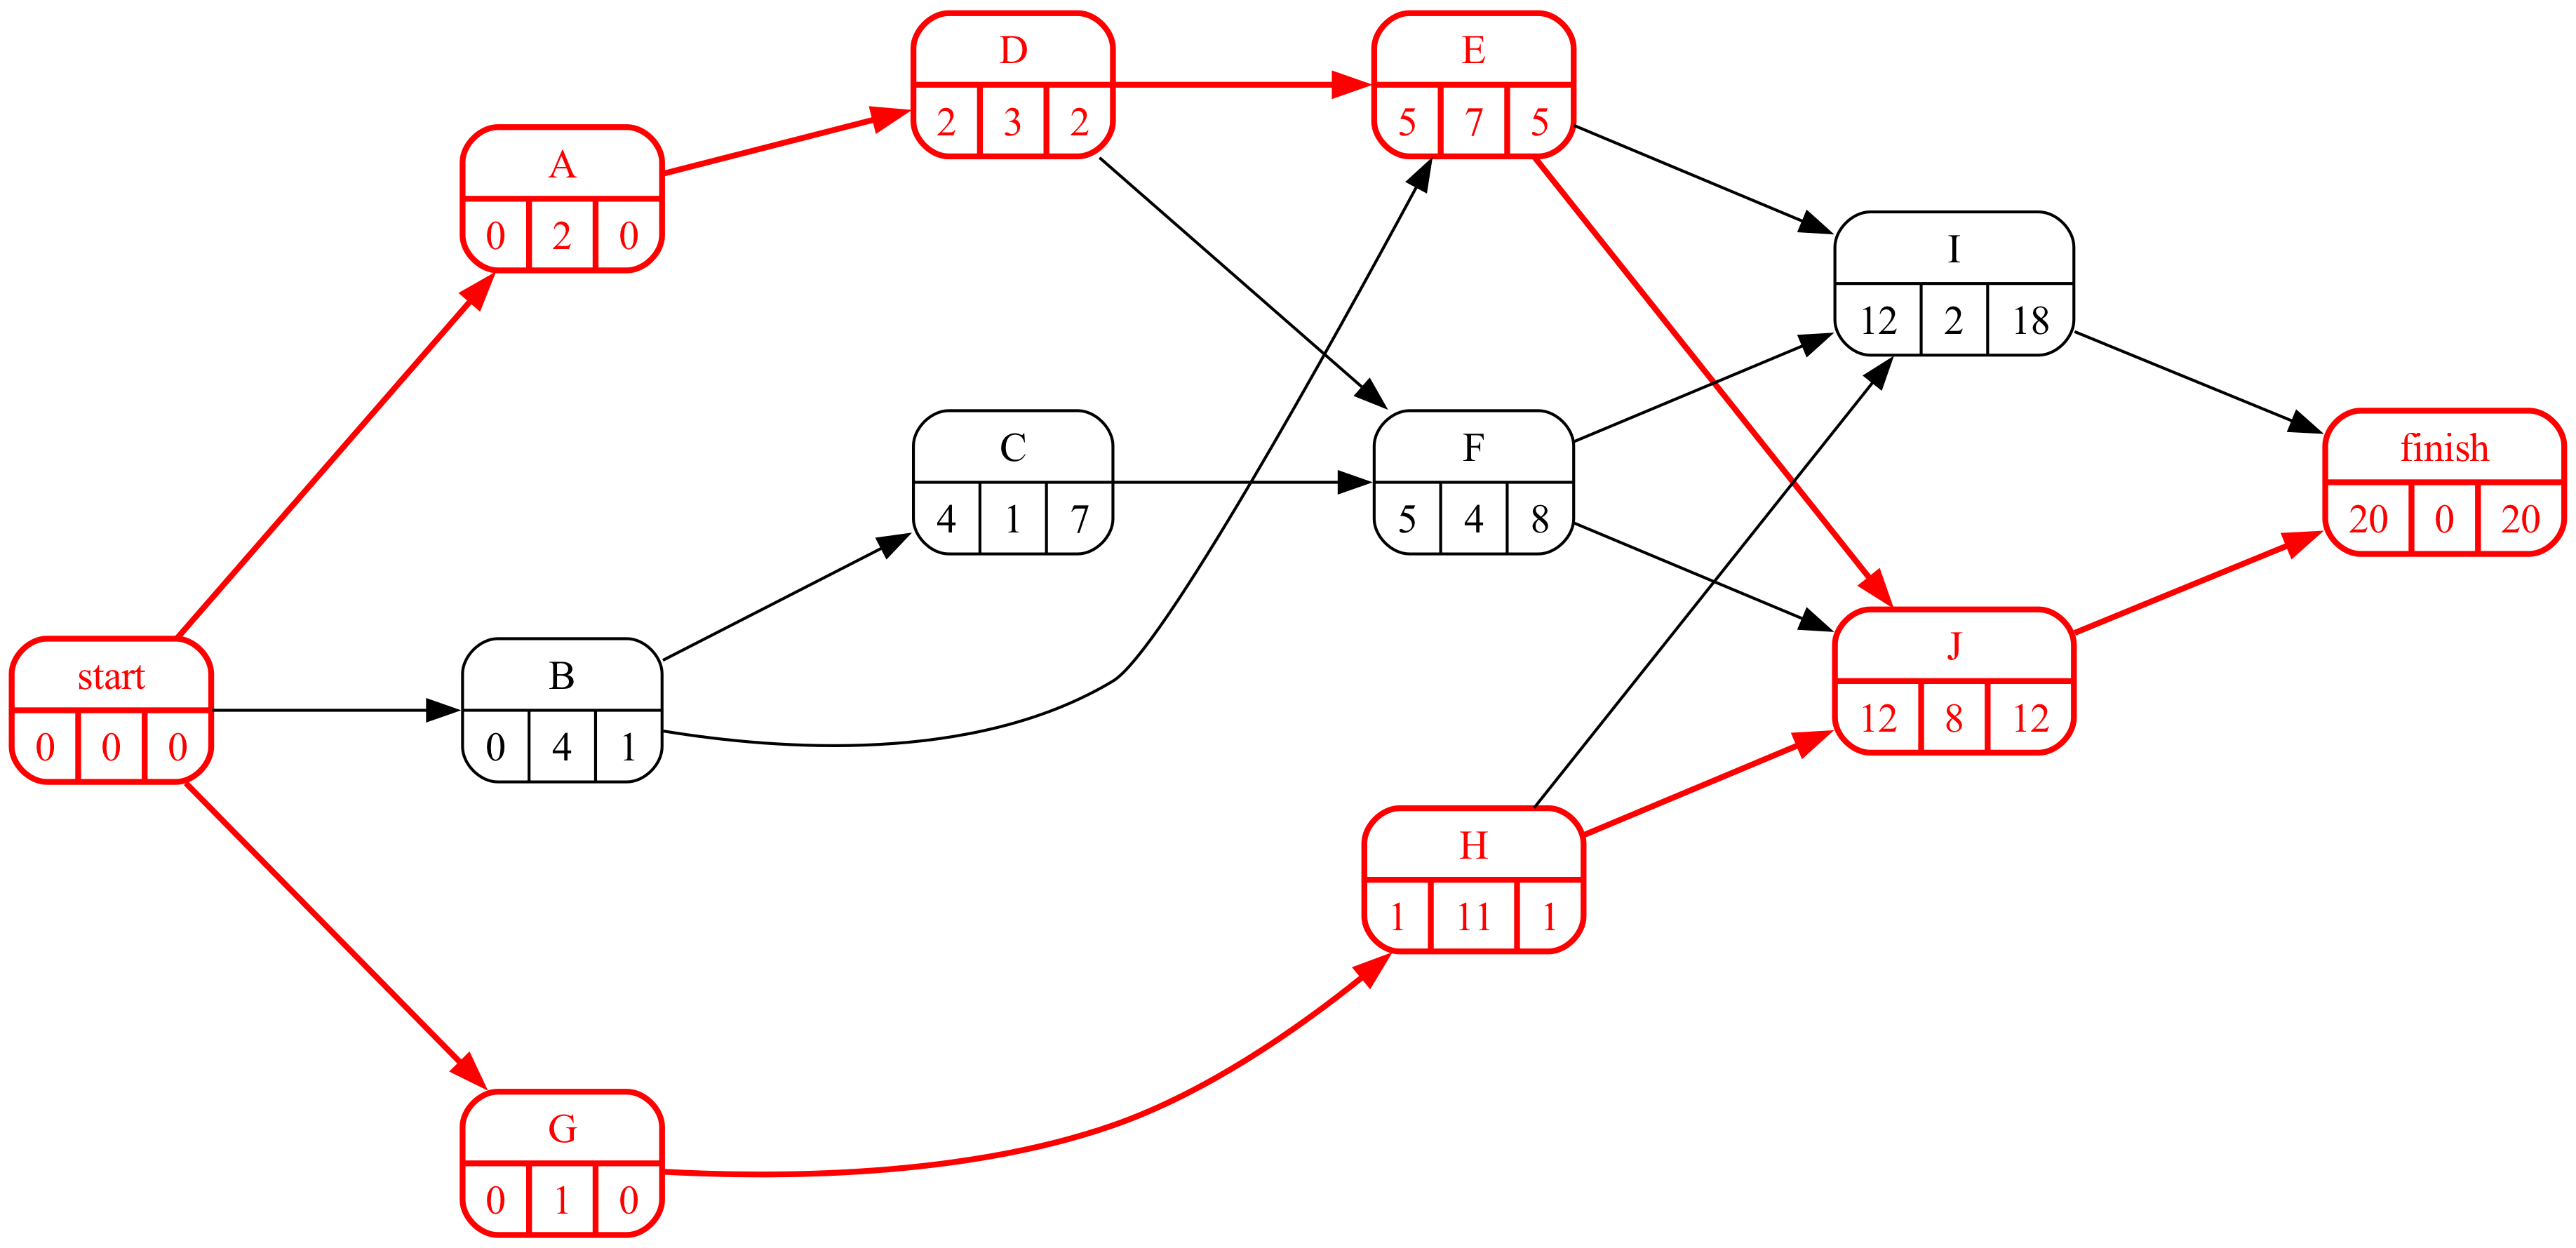

In [17]:
proyecto.roy(durations=datos_proyecto['duration'], ranksep=1.2, nodesep=1.2)

#### Varianza de cada rama

Se calcula entonces la varianza de cada una de las rutas del camino crítico como suma de las varianzas de las actividades que lo componen.

In [18]:
desviacion_proyecto, varianza_caminos = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])

In [19]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas
varianza_caminos

,Activities,Variance
Route_2,"A, D, E, J",4.00
Route_12,"G, H, J",5.00


In [20]:
display(Markdown(f"""La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es {round(desviacion_proyecto**2,2)}.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  """))
display(Markdown(f"La desviación típica es {round(desviacion_proyecto,2)}"""))


La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es 5.0.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  

La desviación típica es 2.24

#### Probabilidad de terminar en el periodo solicitado

In [21]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = norm.cdf(periodo_probabilidad_b, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_a = norm.cdf(periodo_probabilidad_a, loc=duracion_media_proyecto, scale=desviacion_proyecto)


probabilidad_de_terminar_entre_a_y_b = round(float(probabilidad_de_terminar_antes_de_b - probabilidad_de_terminar_antes_de_a), 2)

Markdown(f"Para un proyecto con duración media {duracion_media_proyecto} y desviación típica {round(desviacion_proyecto, 2)} el valor de la probabilidad de terminar en el periodo comprendido entre {periodo_probabilidad_a} y {periodo_probabilidad_b} periodos es {round(probabilidad_de_terminar_entre_a_y_b * 100, 2)} por ciento.")

Para un proyecto con duración media 20 y desviación típica 2.24 el valor de la probabilidad de terminar en el periodo comprendido entre 17 y 19 periodos es 24.0 por ciento.

## Apartado 2


In [22]:
display(Markdown(pregunta_2))

2. Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?  

### Reducción de la duración del proyecto con mínimo coste

In [23]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2,
                report=False,
                )

In [24]:
#| tbl-cap: "Cálculo de la reducción de la duración del proyecto mediante el algoritmo de Ackoff Sasieni"
#| label: tbl-ackoff
ackoff

,A,B,C,D,E,F,G,H,I,J,0,1,2
Route_1,-100.0,,,50.0,20.0,,,,50.0,,14.0,13.0,13.0
Route_2,-100.0,,,50.0,20.0,,,,,5.0,20.0,18.0,18.0
Route_3,-100.0,,,50.0,,10.0,,,50.0,,11.0,10.0,10.0
Route_4,-100.0,,,50.0,,10.0,,,,5.0,17.0,15.0,15.0
Route_5,,30.0,inf,,,10.0,,,50.0,,11.0,11.0,11.0
Route_6,,30.0,inf,,,10.0,,,,5.0,17.0,16.0,16.0
Route_7,,30.0,,,20.0,,,,50.0,,13.0,13.0,13.0
Route_8,,30.0,,,20.0,,,,,5.0,19.0,18.0,18.0
Route_9,,30.0,,,,10.0,,,50.0,,10.0,10.0,10.0
Route_10,,30.0,,,,10.0,,,,5.0,16.0,15.0,15.0


Los desplazamientos indicados al aplicar el algoritmo de reducción con mínimo coste son:

In [25]:
for iteracion, actividades in best_option.items():
    display(Markdown(f"Iteración {iteracion}: " + ", ".join(actividades)))

Iteración 0: A, J

Iteración 1: H

### Probabilidad de terminar antes de 18 periodos
Al ser 18 el valor de la media de la duración, la probabilidad pedida es del 50%.

### Probabilidad de terminar entre 19 y 17 semanas

#### Duración media del proyecto

In [26]:
duracion_media_proyecto = proyecto.duration(duration)

In [27]:
Markdown(f"Nótese como al haber reducido la duración del proyecto, la duración media a utilizar en el cálculo de la probabilidad es la nueva duración recortada de {duracion_media_proyecto} periodos.")

Nótese como al haber reducido la duración del proyecto, la duración media a utilizar en el cálculo de la probabilidad es la nueva duración recortada de 18 periodos.

#### Varianza de la duración del proyecto

Al proyecto le ha surgido una nueva rama. Debemos calcular la varianza de esta nueva rama y actualizar el valor de la varianza del proyecto si fuera menor que la de esta rama.

In [28]:
# duration ha sido calculada en el Ackoff Sasieni
desviacion_proyecto, varianza_caminos = proyecto.standard_deviation(durations=duration,
                                                  variances=datos_proyecto['variance'])

In [29]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas2
varianza_caminos

,Activities,Variance
Route_2,"A, D, E, J",4.00
Route_8,"B, E, J",3.00
Route_12,"G, H, J",5.00


In [30]:
display(Markdown(f"""La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es {round(desviacion_proyecto**2,2)}.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  """))
display(Markdown(f"La desviación típica es {round(desviacion_proyecto,2)}"""))


La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es 5.0.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  

La desviación típica es 2.24

#### Probabilidad de terminar en el periodo solicitado

In [31]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = norm.cdf(periodo_probabilidad_b, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_a = norm.cdf(periodo_probabilidad_a, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_a_y_b = probabilidad_de_terminar_antes_de_b - probabilidad_de_terminar_antes_de_a

Markdown(f"Para un proyecto con duración media {duracion_media_proyecto} y desviación típica {round(desviacion_proyecto, 2)} el valor de la probabilidad de terminar en el periodo comprendido entre {periodo_probabilidad_a} y {periodo_probabilidad_b} periodos es {round(probabilidad_de_terminar_entre_a_y_b * 100, 2)} por ciento.")

Para un proyecto con duración media 18 y desviación típica 2.24 el valor de la probabilidad de terminar en el periodo comprendido entre 17 y 19 periodos es 34.53 por ciento.

## Apartado 3

In [32]:
display(Markdown(pregunta_3))

3. Partiendo del proyecto en su situación inicial del apartado 1 ¿Se encuentran nivelados los recursos consumidos? De no ser así proceda a su nivelación.  

### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda inicial de recursos a lo largo del tiempo.

Suma de cuadrados: 412 



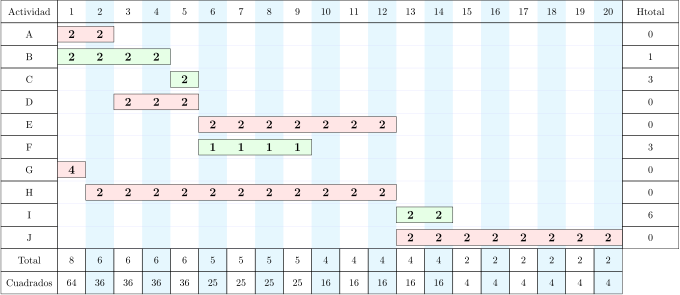

In [33]:
#| fig-cap: "Diagrama de Gantt del proyecto antes de la nivelación"
#| label: fig-ganttPrenivelacion
proyecto_nivelacion = proyecto.copy()
datos_proyecto=datos_enunciado.copy()
_, dibujo = proyecto_nivelacion.gantt_cargas(datos_proyecto, 'duration', 'resources', tikz=True)
pinta_tikz(dibujo)

La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

### Nivelación

La siguiente tabla indica el valor de la suma de los cuadrados del consumo de los recursos para cada unos de los posibles desplazamientos, en el orden de desplazamiento de las actividades utilizado. El orden seguido ha sido el de las actividades no críticas en orden creciente de periodo de finalización. Se señala en color amarillo el desplazamiento que en cada caso minimiza la suma de cuadrados.

In [34]:
proyecto_nivelacion = proyecto.copy()
datos_proyecto = datos_enunciado.copy()

desplazamientos, cuadrados, my_data, gantt_df, dibujo = proyecto_nivelacion.nivelar(
                            data=datos_proyecto,
                            duration_label='duration',
                            resource_label='resources',
                            
                           )

In [35]:
#| tbl-cap: "Suma de los cuadrados de las cargas para cada uno de los desplazamientos posibles con indicación del mínimo en cada actividad"
#| label: tbl-CuadradosNivelacion
cuadrados

,0,1,2,3,4,5,6
activity,,,,,,,
B,412,404,,,,,
C,404,404,404,,,,
F,404,404,404,,,,
I,404,404,404,404,404,404,404


Atendiendo a los valores de las sumas de cuadrados, los desplazamientos indicados para la nivelación son:

In [36]:
#| tbl-cap: "Desplazamientos para la nivelación"
#| label: tbl-desplazamientosNivelación
desplazamientos

,desplazamientos
B,1
C,0
F,0
I,0


El resultado de realizar estos desplazamientos se muestra en el siguiente diagrama de Gantt.

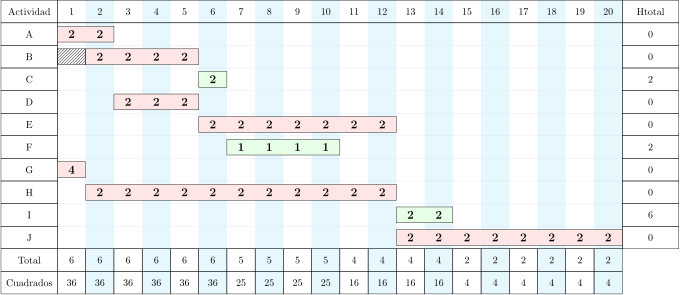

In [37]:
#| fig-cap: "Diagrama de Gantt del proyecto tras la nivelación"
#| label: fig-ganttPostnivelacion
pinta_tikz(dibujo)

## Apartado 4

In [38]:
display(Markdown(pregunta_4))

4. Partiendo del proyecto en su situación inicial del apartado 1, modifique la planificación del proyecto para poder ejecutarlo con tan sólo 4 recursos como máximo durante los primeros tres periodos, y 8 recursos durante el resto del proyecto.  

### Análisis de la situación de partida

Recuperamos el estado inicial del proyecto, como se ve en el siguiente diagrama de Gantt.

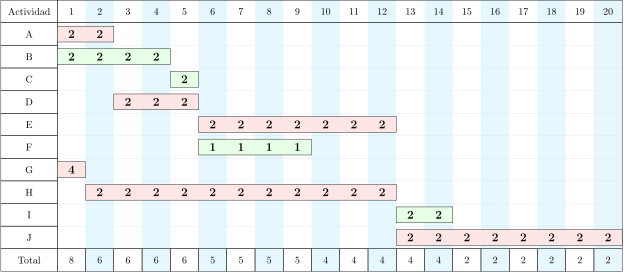

In [39]:
#| fig-cap: "Diagrama de Gantt previo a la asignación"
#| label: fig-ganttPreAsignacion

proyecto_asignacion = proyecto.copy()
datos_proyecto = datos_enunciado.copy()
_, dibujo = proyecto_nivelacion.gantt(datos_proyecto, 'duration', 'resources', total='fila', tikz=True)
pinta_tikz(dibujo)

### Algoritmo de asignación de Wiest-Levy

A continuación se ejecuta el algoritmo de asignación.

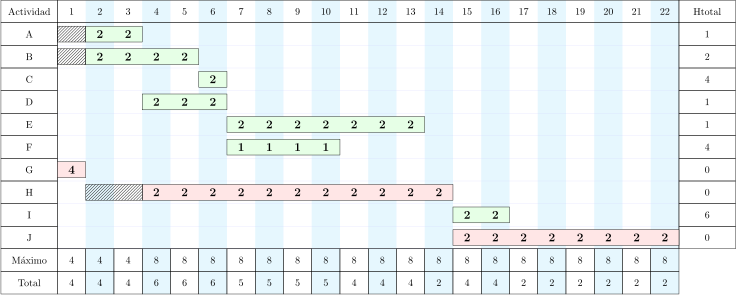

In [40]:
#| fig-cap: "Diagrama de Gantt del proyecto tras la asignación"
#| label: fig-ganttPostAsignación
datos_proyecto_tras_asignar, gantt_df, dibujo = proyecto_asignacion.asignar(data=datos_proyecto,
                                              duration_label='duration',
                                              resource_label='resources',
                                              maximo = [4, 4, 4, 8],
                                              report = False,
                                              params = dict(
                                                  period_width=1
                                                  )
                                              )
pinta_tikz(dibujo)

Tras esta actuación el proyecto ya es compatible con la restricción impuesta en los recursos.